# Using FastAI for creating a Waste Classifier

Fastai is a deep learning library which provides high-level components that can quickly and easily provide state-of-the-art results in standard deep learning domains. 

It has two main design goals: 
1. To be approachable and rapidly productive
2. To be also configurable. 

## Waste Classifier
The aim is to build a model for waste classification that identifies among the different classes: 
- cardboard
- compost
- glass
- metal
- paper
- plastic
- trash

This machine learning model will help people to improve their decision when classifying trash   

## Imports

In [1]:
from fastai.vision.all import *
from fastai.metrics import error_rate, accuracy

from fastai.vision.data import ImageDataLoaders

import warnings
warnings.filterwarnings('ignore')

from os import listdir
!pip install mlxtend
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score


## Load the data

The data is already splitted in train and test folders. Inside each folder contains one folder for each class. Those images were obtained using Bing searcher using the api HTTP.   
Those images has been manually cleaned, removing the ones that were not usefull or where in the wrong category. 
The data has been divided into two sets train and test sets. To divide the data this script has been used: 

In [2]:
BASE_DIR = "/Users/mika/Projects/fastai-waste-classifier"
DATASET_DIR = f"{BASE_DIR}/dataset_splits"
TEST_PHOTOS_DIR = f"{BASE_DIR}/test-photos"

In [3]:
!ls $DATASET_DIR

test  train


In [4]:
!ls $DATASET_DIR/train/glass

glass712.png  glass724.jpg  glass733.jpeg glass746.jpg  glass758.jpg
glass713.png  glass725.png  glass734.jpg  glass747.jpg  glass759.jpg
glass714.jpeg glass726.jpg  glass735.jpg  glass748.jpg  glass760.jpg
glass715.jpg  glass727.jpg  glass736.png  glass751.png  glass761.jpg
glass716.jpg  glass728.jpeg glass740.jpg  glass753.png  glass763.jpg
glass717.jpg  glass729.jpg  glass741.jpg  glass754.jpeg glass764.jpg
glass721.jpg  glass730.jpeg glass744.png  glass755.jpg  glass765.jpg
glass723.jpg  glass732.jpeg glass745.jpg  glass757.jpg  glass767.jpg


## Data augmentation

Apply data augmentation to the training data, keeping 10% the for validation set. Data augmentation process apply some transformations (flip, rotate) to the original images to generate more data to train the model. Plus, helps to avoid overfitting, making the training set less specific. 

The validation set is used to track the model error while training. 


In [5]:
data = ImageDataLoaders.from_folder(
    DATASET_DIR,
    train ='train',
    shuffle=True,
    valid_pct=0.1,
    item_tfms =[ToTensor,RandomResizedCrop(224, min_scale=0.35)],
    batch_tfms=aug_transforms(flip_vert=True, batch=True, max_rotate=30.0),
)

Let's show some of the data for the validation and training sets.

In [6]:
data.valid_ds.items[:3]

[Path('/Users/mika/Projects/fastai-waste-classifier/dataset_splits/train/plastic/trash95.jpg'),
 Path('/Users/mika/Projects/fastai-waste-classifier/dataset_splits/train/trash/trash230.jpg'),
 Path('/Users/mika/Projects/fastai-waste-classifier/dataset_splits/train/metal/metal542.jpg')]

In [7]:
data.train_ds.items[:3]

[Path('/Users/mika/Projects/fastai-waste-classifier/dataset_splits/train/trash/metal202.jpg'),
 Path('/Users/mika/Projects/fastai-waste-classifier/dataset_splits/test/plastic/plastic241.jpg'),
 Path('/Users/mika/Projects/fastai-waste-classifier/dataset_splits/train/cardboard/trash664.jpg')]

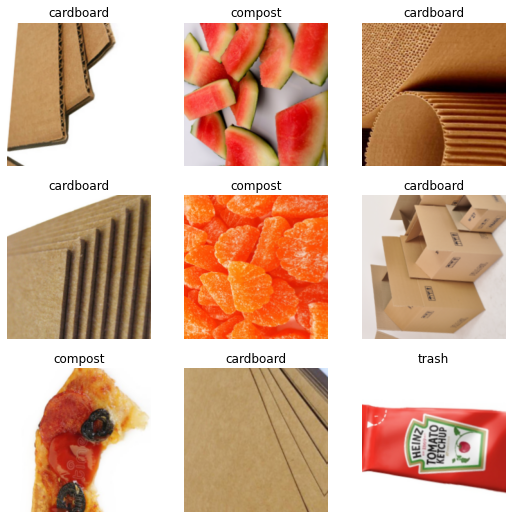

In [8]:
data.train.show_batch()

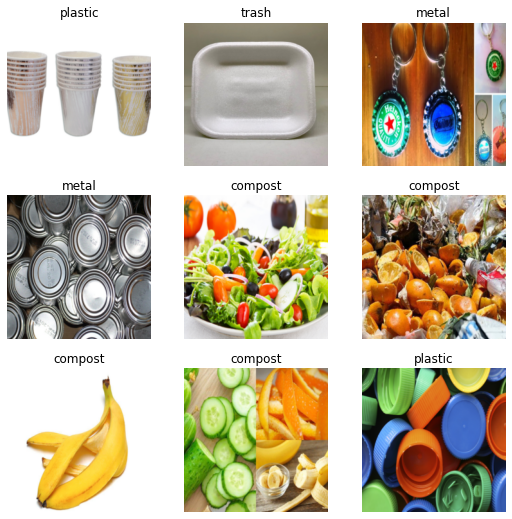

In [9]:
data.valid.show_batch()

In [10]:
data.vocab

['cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'trash']

## Training the model using resnet50

ResNet50 is a convolutional neural network(CNN) that has 50 layers. It has been already trained with images from the ImageNet database. It classifies 1000 object from very broad categories, such as pencil or animals. The input size of the network is 224x224. 

This network can be reused to train other model. 

In [11]:
learn = cnn_learner(data, resnet50, metrics=accuracy)

In [12]:
learn.fine_tune(20)

epoch,train_loss,valid_loss,accuracy,time
0,1.257661,0.786438,0.831081,13:45


epoch,train_loss,valid_loss,accuracy,time
0,0.575526,0.546308,0.861486,18:35
1,0.428046,0.437999,0.871622,18:29
2,0.365136,0.542658,0.854730,30:14
3,0.334401,0.650901,0.871622,18:01
4,0.311998,0.550113,0.888514,18:25
5,0.271527,0.608941,0.854730,19:05
6,0.235148,0.531721,0.871622,17:44
7,0.204505,0.469369,0.885135,17:28
8,0.194769,0.555152,0.881757,17:20
9,0.171995,0.500606,0.885135,50:09


In [13]:
learn.export(fname=f'{BASE_DIR}/result-resnet50.pkl')

In [14]:
learn_loaded = load_learner(f'{BASE_DIR}/result-resnet50.pkl')

Plot the confusion matrix for validation set. The confusion matrix, will show how much of the values has been predicted correctly or not for each class. 

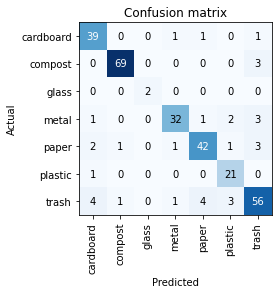

In [15]:
interep = ClassificationInterpretation.from_learner(learn)
interep.plot_confusion_matrix()

## Metrics
Now, let's calculate the accuracy metric for the test set. 
The test set refers to a group of data that has been separated form the training data and the model does not know. 
It contains original images without any transformation. It will reflect how well the model will behave in the real life, when classifying new images.

Let's see what is the result for some photos that we took with the cellphone and check what is the output of the model. 

In [16]:
import utils 

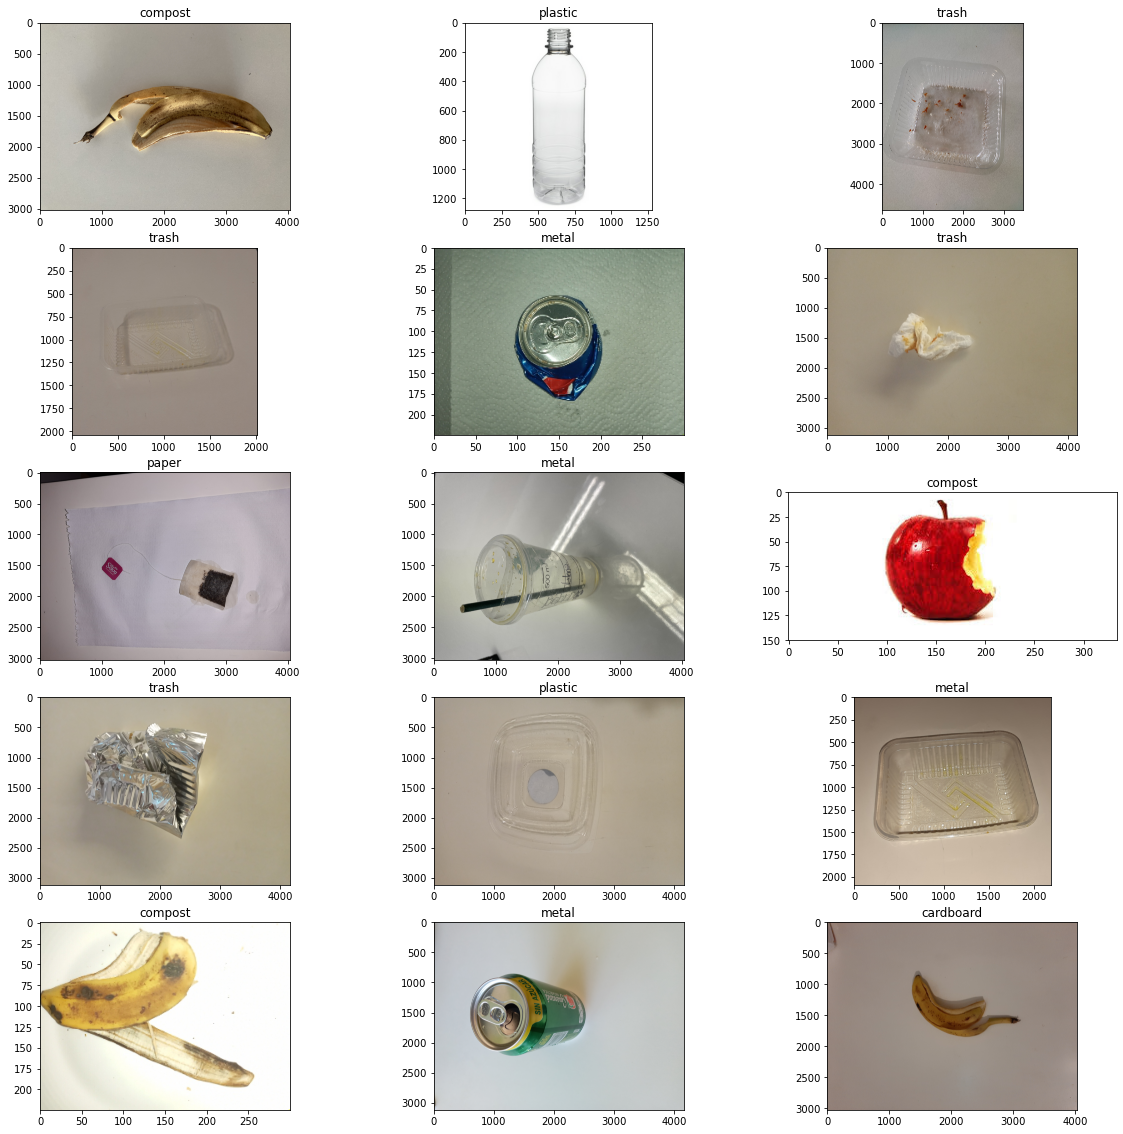

In [17]:
utils.show_predictions(learn_loaded, TEST_PHOTOS_DIR)                      

Accuracy 0.9765100671140939
F1 score 0.9779386698366864
              precision    recall  f1-score   support

   cardboard       0.96      0.97      0.97        80
     compost       0.99      1.00      1.00       153
       glass       1.00      1.00      1.00        10
       metal       0.97      0.98      0.97        58
       paper       1.00      0.96      0.98       116
     plastic       1.00      0.94      0.97        51
       trash       0.94      0.98      0.96       128

    accuracy                           0.98       596
   macro avg       0.98      0.98      0.98       596
weighted avg       0.98      0.98      0.98       596



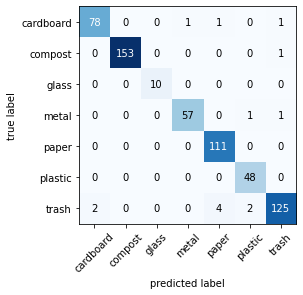

In [18]:
utils.print_results(data.vocab, learn_loaded, f"{DATASET_DIR}/test", 'classification_matrix_resnet50.png')

## Training the model using resnet34
Since we got good accuracy with resnet50, we will try with resnet34 since it has less layers and it is faster to train.

In [19]:
learn = cnn_learner(data, resnet50, metrics=accuracy)
learn.fine_tune(20)
learn.export(fname=f'{BASE_DIR}/result-resnet34.pkl')

epoch,train_loss,valid_loss,accuracy,time
0,1.126824,0.674877,0.793919,19:27


epoch,train_loss,valid_loss,accuracy,time
0,0.552905,0.526061,0.854730,29:02
1,0.428639,0.464075,0.878378,28:41
2,0.345800,0.468639,0.875000,28:37
3,0.310645,0.681562,0.841216,27:33
4,0.311015,0.582133,0.871622,27:36
5,0.259208,0.470999,0.875000,27:24
6,0.250526,0.596694,0.868243,27:41
7,0.228870,0.507958,0.875000,27:45
8,0.192129,0.520283,0.875000,27:47
9,0.170555,0.494904,0.871622,27:43


We can see that also has good accuracy, so we decided to use this model for our final solution

Accuracy 0.9781879194630873
F1 score 0.9779035204473088
              precision    recall  f1-score   support

   cardboard       0.98      0.98      0.98        81
     compost       1.00      1.00      1.00       154
       glass       1.00      1.00      1.00        10
       metal       0.93      0.98      0.96        56
       paper       1.00      0.97      0.98       115
     plastic       0.98      0.96      0.97        49
       trash       0.95      0.97      0.96       131

    accuracy                           0.98       596
   macro avg       0.98      0.98      0.98       596
weighted avg       0.98      0.98      0.98       596



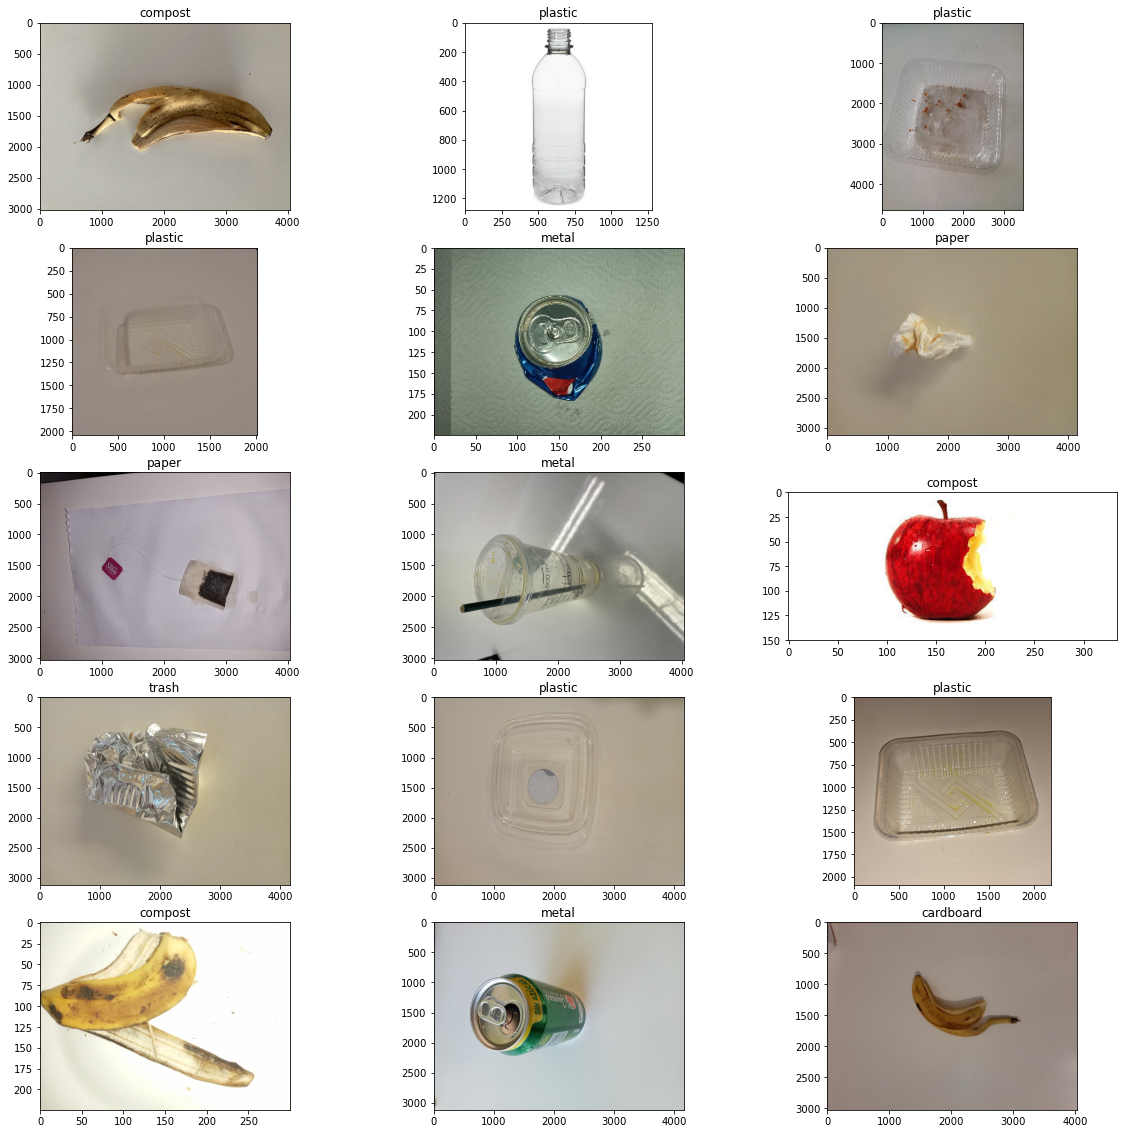

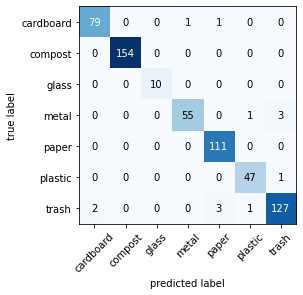

In [20]:
learn_loaded = load_learner(f'{BASE_DIR}/result-resnet34.pkl')
utils.show_predictions(learn_loaded, TEST_PHOTOS_DIR)                      
utils.print_results(data.vocab, learn_loaded, f"{DATASET_DIR}/test", 'classification_matrix_resnet34.png')